In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#préparation des données

In [ ]:
from keras.datasets.mnist import load_data
(x_train, y_train), (x_test, y_test) = load_data()

print("train", x_train.shape, y_train.shape)
print("train", x_test.shape, y_test.shape)

train (60000, 28, 28) (60000,)
train (10000, 28, 28) (10000,)


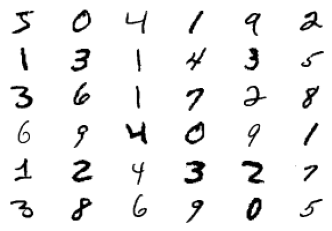

In [ ]:
from matplotlib import pyplot
for i in range(36):
  pyplot.subplot(6,6,1+i)
  pyplot.axis('off')
  pyplot.imshow(x_train[i], cmap='gray_r')

#ne garder que les 0,1 et 2

In [ ]:
def load_012():
  (x_train,y_train), (_, _) = load_data()
  zz=np.zeros(len(y_train))
  idxz = np.where(y_train==zz)
  oo=np.ones(len(y_train))
  idxo = np.where(y_train==oo)
  dd=2*np.ones(len(y_train))
  idxd = np.where(y_train==dd)

  index = np.hstack([idxz[0],idxo[0],idxd[0]])
  sub_train = x_train[index]
  return sub_train,y_train[index]


18623


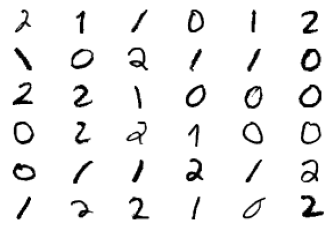

In [ ]:
from matplotlib import pyplot
x_train,y_train = load_012()
print(len(x_train))
i=0
x=np.random.choice(range(len(x_train)), 36)
for index in x:
  pyplot.subplot(6,6,1+i)
  i+=1
  pyplot.axis('off')
  pyplot.imshow(x_train[index], cmap='gray_r')

In [ ]:
from numpy.random.mtrand import randint

def get_number_example(number, xtr, ytr):
  dd=number*np.ones(len(y_train))
  idxd = np.where(y_train==dd)

  return x_train[idxd[0][randint(0,len(idxd[0]),1)[0]]]

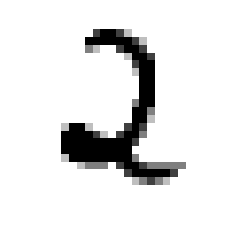

In [ ]:
exemple = get_number_example(2,x_train, y_train)
pyplot.axis('off')
pyplot.imshow(exemple, cmap='gray_r')

#DISCRIMINATOR


In [ ]:
# example of defining the discriminator model
from keras.models import Sequential
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Embedding
from keras.layers import Input
from keras.layers import Concatenate
from keras.layers import Reshape
from keras.utils.vis_utils import plot_model

def define_discriminator(in_shape=(28,28,1),n_classes=3):
  #first input
  in_label = Input(shape=(1,))
  class_embedding = Embedding(n_classes,20)(in_label)
  n_nodes = in_shape[0]*in_shape[1]
  class_img = Dense(n_nodes)(class_embedding)
  class_img = Reshape((in_shape[0],in_shape[1],1))(class_img)

  #second input
  in_image = Input(shape=in_shape)
  #concatenate the two
  merge = Concatenate()([in_image, class_img])
  
  #discriminateur
  cv = Conv2D(16, (4,4), strides=(2,2), padding='same')(merge)
  cv = LeakyReLU(alpha=0.2)(cv)
  cv = Conv2D(10, (7,7), strides=(2,2), padding='same')(cv)
  cv = LeakyReLU(alpha=0.2)(cv)
  fl = Flatten()(cv)
  dp = Dropout(0.4)(fl)
  out = Dense(1,activation='sigmoid')(dp)

  model = Model([in_image, in_label],out)

  opt = Adam(lr=0.0002, beta_1=0.5)
  #adam : un optimisateur de descente de gradient, qui change lr pour aller plus vite au min
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

In [ ]:
model = define_discriminator()

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 1, 20)        60          ['input_25[0][0]']               
                                                                                                  
 dense_24 (Dense)               (None, 1, 784)       16464       ['embedding_12[0][0]']           
                                                                                                  
 input_26 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


data definition/loading/creation functions :

In [ ]:
from numpy.random.mtrand import randint, rand
from numpy import expand_dims
def load_dataset():
  x_train,y_train = load_012()
  X = expand_dims(x_train, axis=-1)
  X = X.astype('float32')
  X = X/255.0
  return [X,y_train]

def generate_real_samples(dataset, n_samples):
  images,labels = dataset
  #get random indices
  idx = randint(0, images.shape[0], n_samples)
  #sample according to indices
  X = images[idx]
  #create labels
  y = np.ones((n_samples, 1))
  return [X,labels[idx]],y

def generate_fake_samples(n_samples,nb_classes):
  #rand is already between 0 and 1
  X = rand(28*28*n_samples)
  X = X.reshape((n_samples, 28, 28))
  labels = randint(0,nb_classes,n_samples)
  y = np.zeros((n_samples, 1))
  return [X,labels],y

training loop :
(feed it half a batch of fake, then again of true, so you can get accuracies on each over time. It doesn't matter that it gets it in batches of same labels as you repeat it many times ; it also has no memory)

In [ ]:
def train_discriminator(model, dataset, n_iter=100, s_batch=256):
  accfake = []
  accreal = []
  for i in range(n_iter):
    s_half_batch = int(s_batch/2)
    #sample real examples
    X_real, y_real = generate_real_samples(dataset, s_half_batch)
    realloss, realacc = model.train_on_batch(X_real, y_real)
    #sample fake examples
    X_fake, y_fake = generate_fake_samples(s_half_batch,3)
    fakeloss, fakeacc = model.train_on_batch(X_fake, y_fake)

    

    print(i+1, " : \nrealacc : ", realacc*100, "\nfakeacc : ", fakeacc*100, '\n')

    print(i+1, " : \nrealloss : ", realloss*100, "\nfakeloss : ", fakeloss*100, '\n')

Launch the experimentation :

In [ ]:
#just testing a prediction
X,y=generate_real_samples(load_dataset(),1)
print(np.array(X[1]).shape)

model = define_discriminator()
model.predict(X)

(1,)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


array([[0.52370435]], dtype=float32)

In [ ]:
#training the discriminator alone just to see if it works
model = define_discriminator()


accuracies = train_discriminator(model, load_dataset())

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1  : 
realacc :  39.84375 
fakeacc :  37.5 

1  : 
realloss :  70.47510743141174 
fakeloss :  70.1886773109436 

2  : 
realacc :  51.5625 
fakeacc :  64.84375 

2  : 
realloss :  69.51689720153809 
fakeloss :  67.59997010231018 

3  : 
realacc :  58.59375 
fakeacc :  75.0 

3  : 
realloss :  68.72320175170898 
fakeloss :  66.92671179771423 

4  : 
realacc :  54.6875 
fakeacc :  75.78125 

4  : 
realloss :  68.91353130340576 
fakeloss :  66.15983247756958 

5  : 
realacc :  51.5625 
fakeacc :  91.40625 

5  : 
realloss :  69.33832168579102 
fakeloss :  64.48661684989929 

6  : 
realacc :  65.625 
fakeacc :  92.1875 

6  : 
realloss :  68.36528778076172 
fakeloss :  63.407325744628906 

7  : 
realacc :  66.40625 
fakeacc :  91.40625 

7  : 
realloss :  68.44085454940796 
fakeloss :  62.90093660354614 

8  : 
realacc :  52.34375 
fakeacc :  96.09375 

8  : 
realloss :  68.41513514518738 
fakeloss :  61.964964866638184 

9  : 
realacc :  64.84375 
fakeacc :  95.3125 

9  : 
realloss :  67.

#GENERATOR


In [ ]:
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

def define_generator(latent_dim,nb_classes):

  in_class = Input(shape=(1,))
  class_embedding = Embedding(nb_classes,10)(in_class)
  class_img = Dense(7*7)(class_embedding)
  class_img = Reshape((7,7,1))(class_img)

  in_latent = Input(shape=(latent_dim,))
  latent_img = Dense(10*7*7)(in_latent)
  latent_img = LeakyReLU(alpha=0.4)(latent_img)
  latent_img = Reshape((7,7,10))(latent_img)

  merge = Concatenate()([class_img,latent_img])

  up = Conv2DTranspose(10,(4,4), strides=(2,2), padding='same')(merge)
  up = LeakyReLU(alpha=0.2)(up)
  up = Conv2DTranspose(10,(4,4), strides=(2,2), padding='same')(up)
  up = LeakyReLU(alpha=0.2)(up)

  out = Conv2D(1, (7,7), activation='sigmoid', padding='same')(up)

  model = Model([in_latent,in_class],out)

  return model

In [ ]:
model = define_generator(100,3)
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 1, 10)        30          ['input_33[0][0]']               
                                                                                                  
 dense_33 (Dense)               (None, 490)          49490       ['input_34[0][0]']               
                                                                                           

using the discriminator :

In [ ]:
import numpy.matlib

def make_vectors(latent_dim, n_samples,n_classes):
  samples = np.matlib.randn(n_samples * latent_dim)
  labels = randint(0,n_classes,n_samples)
  return [samples.reshape(n_samples, latent_dim),labels]

In [ ]:
def generate_generator_images(g_model,n_samples, latent_dim,n_classes):
  vectors,labels = make_vectors(latent_dim, n_samples,n_classes)
  X = g_model.predict([vectors,labels])
  #sans ce reshape on a du 28,28,1 pour les images
  X = X.reshape((n_samples,28,28))
  y=np.zeros((n_samples, 1))

  print("images ------- shape of X : ",X.shape)
  return [X,labels],y

images ------- shape of X :  (20, 28, 28)


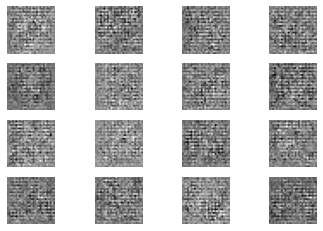

In [ ]:
g_model = define_generator(100,3)
X,y = generate_generator_images(g_model,20, 100,3)
X=X[0]
for i in range(16):
  pyplot.subplot(4,4,1+i)
  pyplot.axis('off')
  pyplot.imshow(X[i], cmap='gray_r')
#voir le warning

#GAN


In [ ]:
def define_gan(g_model, d_model):
  d_model.trainable=False
  
  gen_latent,gen_label = g_model.input
  gen_output = g_model.output
  gan_output = d_model([gen_output,gen_label])

  model = Model([gen_latent,gen_label],gan_output)
  #Adam beta_1 : initial decay rate (so how the lr changes ?)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [ ]:
(data,_),(_,_)= load_data()

d_model = define_discriminator()
#train_discriminator(d_model, load_dataset(), n_iter=50)

g_model = define_generator(100,3)

gan_model = define_gan(g_model, d_model)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
gan_model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_19 (Embedding)       (None, 1, 10)        30          ['input_39[0][0]']               
                                                                                                  
 dense_39 (Dense)               (None, 490)          49490       ['input_40[0][0]']               
                                                                                           

fonction de boucle d'entraînement

In [ ]:
dloss = []
gloss = []

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_classes=3, n_batch=256):
  bat_per_epo = int(int(dataset[0].shape[0])/n_batch)
  half_batch = int(n_batch/2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      X_fake, y_fake = generate_generator_samples(g_model, half_batch, latent_dim,n_classes)
      d_loss1,_ = d_model.train_on_batch(X_fake,y_fake)
      d_loss2,_ = d_model.train_on_batch(X_real,y_real)
      d_loss = (d_loss1+d_loss2)/2.

      X_gan = make_vectors(latent_dim, n_batch,n_classes)
      y_gan = np.ones((n_batch,1))

      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
      dloss.append(d_loss)
      gloss.append(g_loss)
    X,y = generate_generator_images(g_model, 20, 100, n_classes)
    X = X[0]
    for i in range(16):
      pyplot.subplot(4,4,1+i)
      pyplot.axis('off')
      pyplot.imshow(X[i], cmap='gray_r')
      pyplot.show()

In [ ]:
#version sans le reshape
def generate_generator_samples(g_model,n_samples, latent_dim,n_classes):
  vectors,labels = make_vectors(latent_dim, n_samples,n_classes)
  X = g_model.predict([vectors,labels])
  #sans ce reshape on a du 28,28,1 pour les images
  y=np.zeros((n_samples, 1))

  return [X,labels],y

In [ ]:
(data,_),(_,_)= load_data()

d_model = define_discriminator()
#train_discriminator(d_model, load_dataset(), n_iter=50)

g_model = define_generator(100,3)

gan_model = define_gan(g_model, d_model)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


entraînement du gan

In [ ]:
dataset = load_dataset()
train(g_model,d_model, gan_model, dataset, 100, n_epochs=100)

In [ ]:
X,y = generate_generator_images(g_model,20, 100,3)
X=X[0]
for i in range(16):
  pyplot.subplot(4,4,1+i)
  pyplot.axis('off')
  pyplot.imshow(X[i], cmap='gray_r')

In [ ]:
shapedd = np.array(dloss).reshape((100,72))
shapeddmeans = [np.mean([val for val in ep])for ep in shapedd]
shapeddmeans

shapedg = np.array(gloss).reshape((100,72))
shapedgmeans = [np.mean([val for val in ep])for ep in shapedg]
shapedgmeans

In [ ]:
for i in range(5,95):
  shapeddmeans[i]=np.mean([shapeddmeans[i-3],shapeddmeans[i-2],shapeddmeans[i-1],shapeddmeans[i],shapeddmeans[i+1],shapeddmeans[i+2],shapeddmeans[i+3]])

In [ ]:
plt.figure(figsize=(15,5))
plt.axes().set(facecolor=(.6,.7,.9,1.))
plt.plot(range(100), shapeddmeans, color=(.8,1.,.6,1.),label='discriminateur')
plt.plot(range(100), shapeddmeans,'o', color=(.8,1.,.6,1.))


plt.plot(range(100), shapedgmeans, color=(1.,0.8,.6,1.),label='generateur')
plt.plot(range(100), shapedgmeans,'o', color=(1.,0.8,.6,1.))

plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss (binary cross entropy)")
plt.grid(axis="both", linewidth=2, color=(.45,.55,.75,1.))
plt.title("évolution de la fonction de coût des deux modèles (conditional GAN)")

plt.show()